In [31]:
import numpy as np 
import pandas as pd
# import os 
import csv
import matplotlib
import matplotlib.pyplot as plt
from scipy.integrate import quad
from CosmologyCalculatorPC import CosmologyCalculatorPC
import time
from joblib import Parallel, delayed

In [2]:
# GENERAL PLOT OPTIONS
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['xtick.bottom'] = True
matplotlib.rcParams['xtick.top'] = False
matplotlib.rcParams['ytick.right'] = False
matplotlib.rcParams['axes.edgecolor'] = 'black'
matplotlib.rcParams['axes.linewidth'] = '1.0'
matplotlib.rcParams['axes.labelsize'] = 'medium'
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.linewidth'] = '0.0'
matplotlib.rcParams['grid.alpha'] = '0.18'
matplotlib.rcParams['grid.color'] = 'lightgray'
matplotlib.rcParams['legend.labelspacing'] = 0.77
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['savefig.format'] = 'pdf'

#plt.figure(figsize = (3.5,3.5))

In [3]:
cmag = 149896229/500

In [4]:
def dyn_w(z, w0, wa):
    return w0 + wa *( z / (1 + z))

In [5]:
def integrand1(z, w0, wa):
        return (1 + dyn_w(z, w0, wa)) / (1 + z)
    
def OmegaDE(z, w0, wa):
    result, error = quad(integrand1, 0, z, args=(w0,wa))
    return np.exp(3 * result)
   
    


In [6]:
NNU = 3.04
TCMB = 2.725
OGhh = 4.4856 * 1e-7 * pow(TCMB,4)
ONhh = 1.0187 * 1e-7 * NNU * pow(TCMB,4)
ORhh = ONhh + OGhh

In [7]:
def HubbleVer2(z, w0, wa, H0, Om, Ok):

    # Calculate derived values as per the Mathematica code
    h = H0 / 100
    Omh2 = Om * (H0 / 100) ** 2
    x = Omh2 / Om - Omh2 - Ok * Omh2 / Om - ORhh

    # Handle potential bad input for Om or Ok
    if x < 0:
        raise ValueError(f"Bad input: Om={Om}, Ok={Ok}")

    # Calculate Hubble parameter using OmegaDE
    result = 100 * np.sqrt(Omh2 * (1 + z) ** 3 + x * OmegaDE(z,w0,wa) +
                           Ok * h ** 2 * (1 + z) ** 2 + ORhh * (1 + z) ** 4)

    return result

In [8]:
def DL(z, w0, wa, H0, Om, Ok):
    def integrand(z, w0, wa, H0, Om, Ok):
        return 1 / HubbleVer2(z, w0, wa, H0, Om, Ok)
        
    result, error = quad( integrand, 0, z, args=(w0,wa, H0, Om, Ok))
    # Return the luminosity distance
    return cmag * result * (1 + z)


In [9]:
def m(z, w0, wa, H0, Om, Ok, M):
    return 5 * np.log10(H0 / cmag * DL(z, w0, wa, H0, Om, Ok)) + M


## SN Fisher -- Definitions of errors

In [10]:
Nx = 1000
zzmin = 0.03
zzmax = 1.7
zBinsFisher = np.array([zzmin + i * (zzmax - zzmin) / Nx for i in range(1, Nx + 1)])
zbins = np.insert(zBinsFisher, 0, 0.03)

NSN = [0, 300, 35, 64, 95, 124, 150, 171, 183, 179, 170, 155, 142, 130, 119, 107, 94, 80, 0 ]
zSN = [0.03, 0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75 ]

dz1 = 0.1
dz2 = 0.07
tmp = zBinsFisher[1] - zBinsFisher[0]
fnSN = np.interp(zBinsFisher, zSN, NSN)
sigma2SNfisher = []

for i, z in enumerate(zBinsFisher):
    if z < 0.1:
        dz = dz2
    else:
        dz = dz1
    
    sigma2SNfisher.append(
        dz / tmp * (0.15**2 / fnSN[i] + 0.02**2 * ((1 + z) / 2.7)**2)
    )

sigma2SNfisher = np.array(sigma2SNfisher)

# Construct the $\log d_L(z)$ using the PCs

In [11]:
# Redshifts for the bins that we chose when we did the eigevector analysis with Fisher.

Nx = 1000
zzmin = 0.03
zzmax = 1.7
zBinsFisher = np.array([zzmin + i * (zzmax - zzmin) / Nx for i in range(1, Nx + 1)])
zbins = np.insert(zBinsFisher, 0, 0.03)

alphasfid = np.array([0] * Nx) # When all amplitudes are zero, I get back ΛCDM

eigenvectors = np.loadtxt("/mnt/c/Users/asgia/Desktop/cosmo_stuff/eigenvectorsFisherTot_ver2_1000PCs_0p03_to_1p7.dat")
#eigenvectors = np.loadtxt("/mnt/c/Users/asgia/Desktop/cosmo_stuff/eigenvectorsFisherTot_ver2.dat")

eigenvectors.shape

(1000, 1000)

In [12]:
# Function that does the projection of the analytic result on to the PC basis.
def calculate_alphasQ(dyn_w_array, eigenvectors, Nx):
    alphasQ = []
    for i in range(Nx):
        a = np.sum((dyn_w_array + 1) * eigenvectors[i][:])
        alphasQ.append(a)
    return np.array(alphasQ)


In [22]:
Nx=1000
dyn_w_list = [dyn_w(z, -0.827, -0.75) for z in zBinsFisher]
dyn_w_array = np.array(dyn_w_list)
alphasQ = calculate_alphasQ(dyn_w_array, eigenvectors, Nx)

In [14]:
calculatorNx = CosmologyCalculatorPC(73, 0.24, 0, alphasQ, eigenvectors)

In [19]:
analytic_m_array = [ m(z, -0.827, -0.75, 73, 0.24, 0, 25) for z in zBinsFisher]

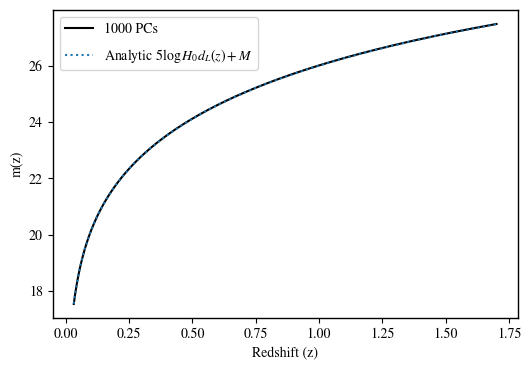

In [20]:
plt.figure(figsize=(6, 4))
plt.plot(zBinsFisher, 5*calculatorNx.logH0lum_distance(zbins, zBinsFisher) + 25, color='black', label=rf'{Nx} PCs')
plt.plot(zBinsFisher, analytic_m_array, label=r'Analytic $5 \log H_0 d_L(z) + M$', linestyle=':')
plt.xlabel('Redshift (z)')
plt.ylabel(r'm(z)')
#plt.title(r'')
# plt.xlim(1.5,1.7)
# plt.ylim(10500,13000 )
plt.legend()
plt.grid(True)
plt.show()

## Define $\Delta \chi^2$ and plot

In [17]:
# This function will take as input the m(z) and will return the chi squared as defined in equation A6 of 0810.1744
def criterion(f_pc, f_exp, sigma_sq):
    ''' All the inputs are numpy arrays '''
    return (f_exp - f_pc ) ** 2 / sigma_sq

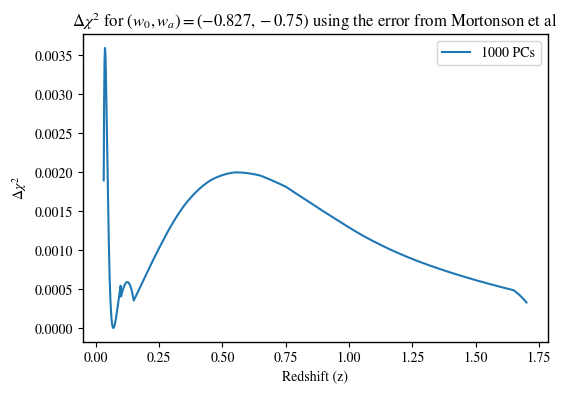

In [18]:
plt.figure(figsize=(6, 4))
plt.plot(zBinsFisher, criterion(5*calculatorNx.logH0lum_distance(zbins, zBinsFisher) + 20, analytic_m_array, sigma2SNfisher) , label=rf'{Nx} PCs')

#plt.yscale('log')
plt.xlabel('Redshift (z)')
plt.ylabel(r'$\Delta \chi^2$')
plt.title(r'$\Delta\chi^2$ for $(w_0, w_a)=(-0.827, -0.75)$ using the error from Mortonson et al ')
plt.legend()
plt.grid(True)
plt.show()

## Completeness test

In [25]:
analytic_m_array = [ m(z, -0.827, -0.75, 73, 0.24, 0, 25) for z in zBinsFisher]
Nx=1000
dyn_w_list = [dyn_w(z, -0.827, -0.75) for z in zBinsFisher]
dyn_w_array = np.array(dyn_w_list)
alphas_proj= calculate_alphasQ(dyn_w_array, eigenvectors, Nx)

# ombh2 = 0.2 * cosmo_params[0] ** 2 * cosmo_params[1] / 10000
# omch2 = 0.8 * cosmo_params[0] ** 2 * cosmo_params[1] / 10000

def compute_chisq_dyn(w0, wa, cosmo_params, NPC):

    # Run my method for the same cosmological parameters and the chosen number of PCs
    if NPC == None:
        calc = CosmologyCalculatorPC(cosmo_params[0], cosmo_params[1], 0, alphas_proj, eigenvectors)
    else:
        calc = CosmologyCalculatorPC(cosmo_params[0], cosmo_params[1], 0, alphas_proj[:NPC], eigenvectors[:NPC])
    
    # Calculate the luminosity distances for the two methods
   
    mym = 5 * calc.logH0lum_distance(zbins, zBinsFisher) + 25
    
    # Compare the distances and get a chi^2
    chisq = np.sum(criterion(mym, analytic_m_array, sigma2SNfisher))
    
    return w0, wa, chisq

In [32]:
# Start the timer
start_time = time.time()

# Parallelize the loop using joblib
n_jobs = -1  # Use all available CPU cores
results = Parallel(n_jobs=n_jobs)(
    delayed(lambda NPC: (*compute_chisq_dyn(-0.827, -0.75, [73, 0.24], NPC), NPC))(NPC) 
    for NPC in range(1,1001)
)

# Store results in a DataFrame, including NPC as a column
chisq_compare_NPC = pd.DataFrame(results, columns=['w0', 'wa', 'chisq', 'NPC'])

# End the timer
end_time = time.time()

# Print the total execution time
total_time = end_time - start_time
print(f"Total execution time: {total_time:.2f} seconds")



Total execution time: 6.52 seconds


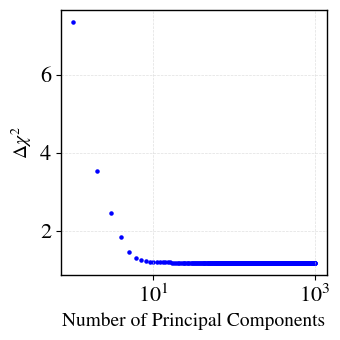

In [47]:
# Plotting chi-squared vs NPC

plt.figure(figsize=(3.5, 3.5))
plt.scatter(chisq_compare_NPC['NPC'], chisq_compare_NPC['chisq'], s=5, color='blue')
plt.xlabel('Number of Principal Components', fontsize=14)
plt.ylabel(r'$\Delta \chi^2$', fontsize=14)
plt.xscale('log')
#plt.yscale('log') 
#plt.ylim(1.18,1.25)
#plt.title(r'$\chi^2$ vs Number of PC for $(w_0,w_a) = (-0.827, -0.75)$')
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
#plt.savefig("/home/venus/cosmo_stuff/emul2024/artemis/chiSq_vs_number_of_PCs.pdf", format="pdf", bbox_inches="tight")
plt.show()